# NLP Binary Classification - Sarcasm Dataset

Determine if news headlines are sarcastic or not.

In [1]:
import urllib
import json
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the Data

...as well as some global variables.

In [4]:
# Load the data
url = 'https://storage.googleapis.com/download.tensorflow.org/data/sarcasm.json'
urllib.request.urlretrieve(url, 'sarcasm.json')

sentences = []
labels = []

with open('sarcasm.json', 'r') as file:
    sarcasm_data = json.load(file)

for item in sarcasm_data:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])


In [5]:
# Test some of the values
print(sentences[:10])
print(labels[:10])

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way', "advancing the world's women", 'the fascinating case for eating lab-grown meat', 'this ceo will send your kids to school, if you work for his company', 'top snake handler leaves sinking huckabee campaign', "friday's morning email: inside trump's presser for the ages"]
[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]


# Process the data for training

In [4]:
# Some global variables
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [5]:
# Split the data
train_sent = sentences[:training_size]
train_label = labels[:training_size]

test_sent = sentences[training_size:]
test_label = labels[training_size:]

In [6]:
# Init the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate word index
tokenizer.fit_on_texts(train_sent)

# Get the word index
word_index = tokenizer.word_index
print(f'The word count is {len(word_index)}.')

# Generate and pad the training sequences - DID I FUCK THIS UP? NO. DID NOT MATTER
train_seq = tokenizer.texts_to_sequences(train_sent)
train_pad = pad_sequences(train_seq, maxlen=max_length, truncating=trunc_type, padding=padding_type)

# Generate and pad the testing sequences
test_seq = tokenizer.texts_to_sequences(test_sent)
test_pad = pad_sequences(test_seq, maxlen=max_length, truncating=trunc_type, padding=padding_type)

The word count is 25637.


In [7]:
# Convert the labels to numpy arrays
train_label = np.array(train_label)
test_label = np.array(test_label)

In [8]:
# See the shape of one train and test sequence
print(train_pad[15:25])
print(test_pad[15:25])
print(f'Each sequence is {len(train_pad[0])} words long.')

[[524   1   1 ...   0   0   0]
 [  1   1 341 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 ...
 [  1   1   1 ...   0   0   0]
 [ 20  11  46 ...   0   0   0]
 [608 478 824 ...   0   0   0]]
[[  4   1  90 ...   0   0   0]
 [  1 760 277 ...   0   0   0]
 [102  23   9 ...   0   0   0]
 ...
 [ 56   1   2 ...   0   0   0]
 [ 28  11  29 ...   0   0   0]
 [  1 544 641 ...   0   0   0]]
Each sequence is 120 words long.


# Build the model

This is a many-to-one NLP model.

In [20]:
model = tf.keras.Sequential([
    # Make the embeddings
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),

    # 1 Bi-LSTM
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(120, return_sequences=True)),

    # 1 Conv1D
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAvgPool1D(),

    # One hidden layer and one output layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           16000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 120, 240)         131520    
 nal)                                                            
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          153728    
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [21]:
# Set up early stopping when accuracy stops growing
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    mode='max',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [22]:
# Test time
#total epochs is 70
history = model.fit(
    train_pad,
    train_label,
    epochs=50,
    validation_data=(test_pad, test_label),
    callbacks=[callback]
)

Epoch 1/50
625/625 [==============================] - 20s 26ms/step - loss: 0.5158 - accuracy: 0.7321 - val_loss: 0.4006 - val_accuracy: 0.8122
Epoch 2/50
625/625 [==============================] - 9s 15ms/step - loss: 0.3850 - accuracy: 0.8264 - val_loss: 0.3966 - val_accuracy: 0.8173
Epoch 3/50
625/625 [==============================] - 9s 14ms/step - loss: 0.3701 - accuracy: 0.8328 - val_loss: 0.4059 - val_accuracy: 0.8177
Epoch 4/50
625/625 [==============================] - 9s 15ms/step - loss: 0.3541 - accuracy: 0.8370 - val_loss: 0.3815 - val_accuracy: 0.8286
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 0.3337 - accuracy: 0.8504 - val_loss: 0.3863 - val_accuracy: 0.8211
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 0.3238 - accuracy: 0.8576 - val_loss: 0.3869 - val_accuracy: 0.8267
Epoch 7/50
625/625 [==============================] - 8s 12ms/step - loss: 0.3209 - accuracy: 0.8619 - val_loss: 0.4052 - val_accuracy: 0.826

# Visualize Training

In [23]:
# Import matplotlib
import matplotlib.pyplot as plt

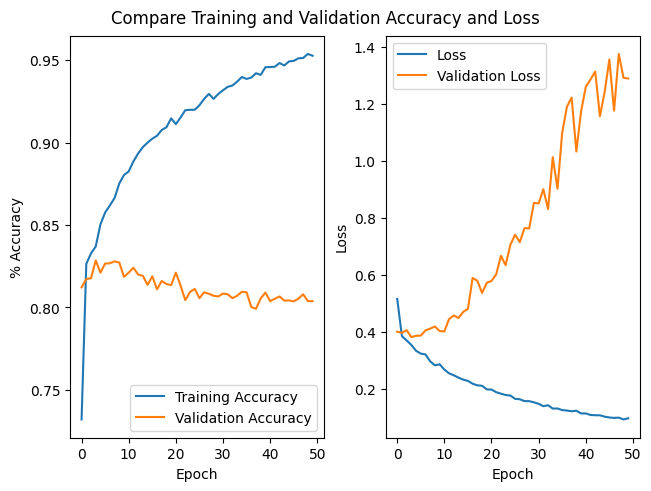

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
fig.suptitle('Compare Training and Validation Accuracy and Loss')

ax1.plot(history.epoch, history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.epoch, history.history['val_accuracy'], label='Validation Accuracy')
ax1.legend()
ax1.set(xlabel='Epoch', ylabel='% Accuracy')

ax2.plot(history.epoch, history.history['loss'], label='Loss')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation Loss')
ax2.legend()
ax2.set(xlabel='Epoch', ylabel='Loss')

fig.show()

So a terrible amout of overfitting has occurred. One should probably change to model structure to fix this issue.

For another time...